In [2]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Analyser le nombre d'images et classes

In [7]:
dataset = "Celebrity Faces Dataset"

In [8]:
classes = os.listdir(dataset)
num_classes = len(classes)
num_images_per_class = {cls: len(os.listdir(os.path.join(dataset, cls))) for cls in classes}

Nombre de stars, nombre d'images de star et dimension moyen des images

In [10]:
# Dimensions des images
image_sizes = []
for cls in classes:
    cls_path = os.path.join(dataset, cls)
    for image_name in os.listdir(cls_path):
        img = Image.open(os.path.join(cls_path, image_name))
        image_sizes.append(img.size)

avg_size = np.mean(image_sizes, axis=0)

print(f"Nombre de classes : {num_classes}")
print(f"Nombre moyen d'images par classe : {np.mean(list(num_images_per_class.values()))}")
print(f"Dimensions moyennes des images : {avg_size}")

Nombre de classes : 17
Nombre moyen d'images par classe : 105.88235294117646
Dimensions moyennes des images : [455.09888889 496.41611111]


Redimensionnement des images pour l'entrainement avec un reseau CNN

In [11]:
image_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(dataset, target_size=image_size, batch_size=batch_size, subset="training")
val_data = datagen.flow_from_directory(dataset, target_size=image_size, batch_size=batch_size, subset="validation")

Found 1440 images belonging to 17 classes.
Found 360 images belonging to 17 classes.


In [17]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement
history = model.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 428ms/step - accuracy: 0.0822 - loss: 3.5174 - val_accuracy: 0.1111 - val_loss: 2.7654
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 405ms/step - accuracy: 0.1334 - loss: 2.7058 - val_accuracy: 0.1944 - val_loss: 2.4577
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step - accuracy: 0.2507 - loss: 2.2930 - val_accuracy: 0.2750 - val_loss: 2.2516
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 405ms/step - accuracy: 0.4589 - loss: 1.6698 - val_accuracy: 0.2667 - val_loss: 2.3144
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 391ms/step - accuracy: 0.6909 - loss: 1.0489 - val_accuracy: 0.3389 - val_loss: 2.8681
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 393ms/step - accuracy: 0.8851 - loss: 0.4086 - val_accuracy: 0.3361 - val_loss: 3.2476
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9368 - loss: 0.2256 - val_accuracy: 0.3361 - val_loss: 4.3550
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 378ms/step - accuracy: 0.9801 - loss: 0.0888 - val_accu

In [19]:
# Évaluation
test_data = datagen.flow_from_directory(dataset, target_size=image_size, batch_size=batch_size, subset="validation")
loss, accuracy = model.evaluate(test_data)
print(f"Précision du modèle : {accuracy}")

Found 360 images belonging to 17 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.3580 - loss: 8.1536
Précision du modèle : 0.375


Prédiction et affichage des images pour tester 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


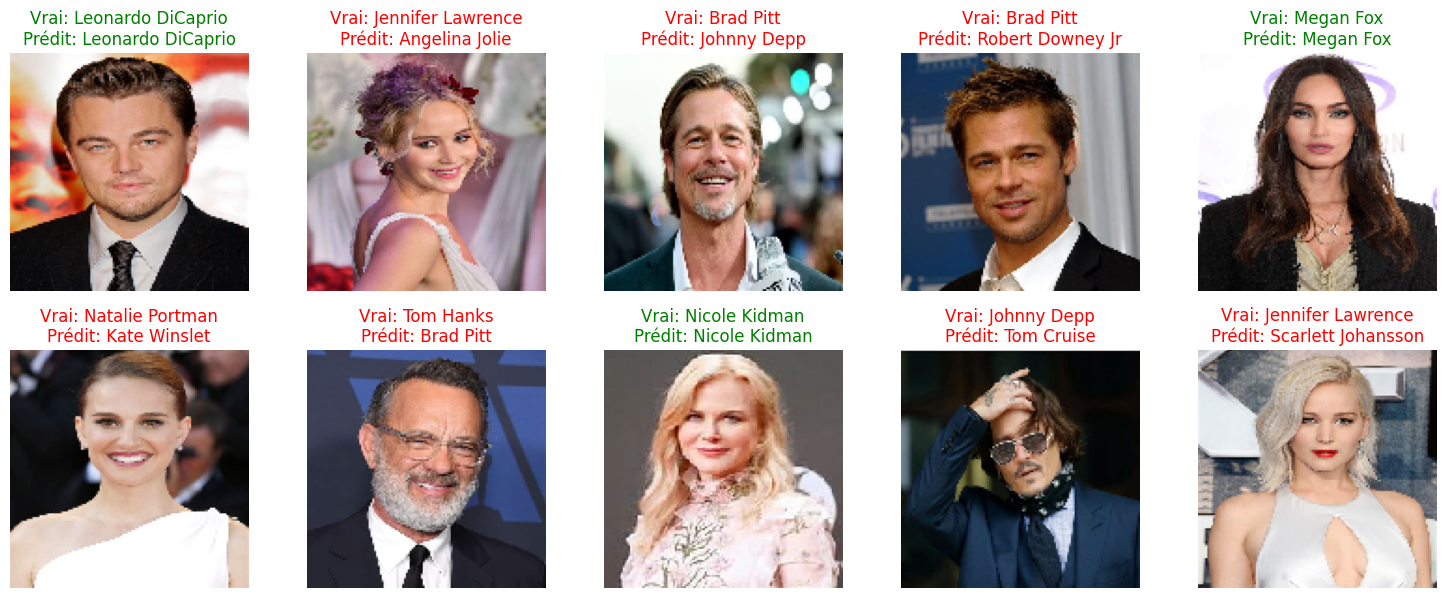

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

def display_predictions(model, test_data, class_names, num_images=10):

    # Récupérer un batch d'images
    test_images, test_labels = next(test_data)

    # Faire des prédictions
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    # Affichage
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(test_images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(test_images[i])
        plt.axis("off")
        
        # Titre : étiquette réelle vs prédiction
        true_label = class_names[true_classes[i]]
        predicted_label = class_names[predicted_classes[i]]
        color = "green" if true_classes[i] == predicted_classes[i] else "red"
        plt.title(f"Vrai: {true_label}\nPrédit: {predicted_label}", color=color)

    plt.tight_layout()
    plt.show()


# Liste des noms de classes
class_names = list(train_data.class_indices.keys())

# Afficher 10 prédictions
display_predictions(model, test_data, class_names, num_images=10)

Entrainement du modéle par Transfert Learning avec MobileNet V2

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Charger MobileNet V2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Geler les couches de base

In [23]:
# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler et entraîner
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 409ms/step - accuracy: 0.1941 - loss: 2.5492 - val_accuracy: 0.3472 - val_loss: 1.9316
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.4497 - loss: 1.6119 - val_accuracy: 0.4889 - val_loss: 1.5313
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.6565 - loss: 1.1205 - val_accuracy: 0.5000 - val_loss: 1.3982
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7550 - loss: 0.8732 - val_accuracy: 0.5472 - val_loss: 1.4878
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.8638 - loss: 0.5958 - val_accuracy: 0.5472 - val_loss: 1.2945
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9058 - loss: 0.4739 - val_accuracy: 0.5750 - val_loss: 1.2372
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9600 - loss: 0.3326 - val_accuracy: 0.6028 - val_loss: 1.2287
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9768 - loss: 0.2449 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


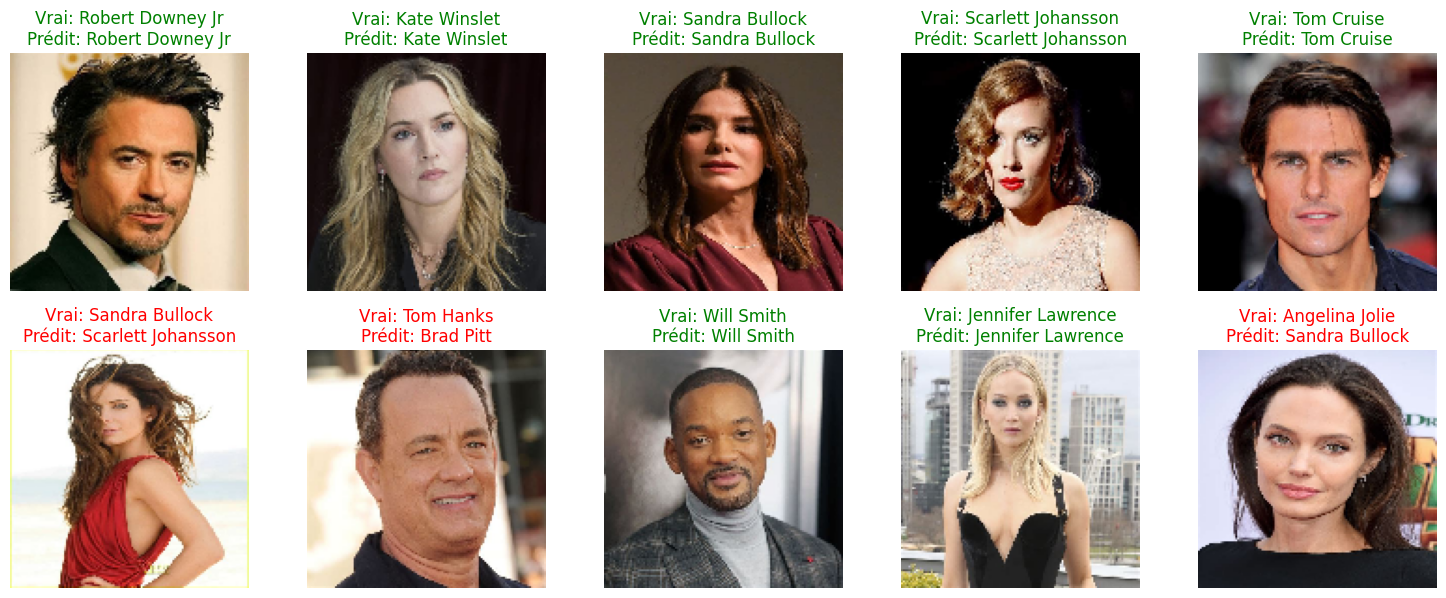

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

def display_transfer_learning_predictions(model, test_data, class_names, num_images=10):
    """
    Affiche les images et leurs classes prédites après un entraînement par transfert learning.
    
    Args:
    - model : Modèle entraîné avec transfert learning.
    - test_data : Générateur ou lot contenant les images et labels.
    - class_names : Liste des noms des classes.
    - num_images : Nombre d'images à afficher (par défaut : 10).
    """
    # Obtenir un batch d'images
    test_images, test_labels = next(test_data)
    
    # Prédictions sur le batch
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    
    # Affichage des images et des prédictions
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(test_images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(test_images[i])
        plt.axis("off")
        
        # Titre affichant la vérité et la prédiction
        true_label = class_names[true_classes[i]]
        predicted_label = class_names[predicted_classes[i]]
        color = "green" if true_classes[i] == predicted_classes[i] else "red"
        plt.title(f"Vrai: {true_label}\nPrédit: {predicted_label}", color=color)
    
    plt.tight_layout()
    plt.show()
    
# Obtenir les noms des classes
class_names = list(train_data.class_indices.keys())

# Afficher les prédictions sur les données de test
display_transfer_learning_predictions(model, test_data, class_names, num_images=10)
